In [15]:
import glob, os, torch
from depth_anything_3.api import DepthAnything3
device = torch.device("cuda")
model = DepthAnything3.from_pretrained("depth-anything/DA3NESTED-GIANT-LARGE")
model = model.to(device=device)
example_path = "assets/examples/sample"
images = sorted(glob.glob(os.path.join(example_path, "*.png")))
prediction = model.inference(
    images,
)
# prediction.processed_images : [N, H, W, 3] uint8   array
print(prediction.processed_images.shape)
# prediction.depth            : [N, H, W]    float32 array
print(prediction.depth.shape)  
# prediction.conf             : [N, H, W]    float32 array
print(prediction.conf.shape)  
# prediction.extrinsics       : [N, 3, 4]    float32 array # opencv w2c or colmap format
print(prediction.extrinsics.shape)
# prediction.intrinsics       : [N, 3, 3]    float32 array
print(prediction.intrinsics.shape)

[INFO ] using SwiGLU layer as FFN
[INFO ] using MLP layer as FFN
[INFO ] using MLP layer as FFN
[INFO ] Processed Images Done taking 0.05200600624084473 seconds. Shape:  torch.Size([6, 3, 504, 280])
[INFO ] Processed Images Done taking 0.05200600624084473 seconds. Shape:  torch.Size([6, 3, 504, 280])
[INFO ] Model Forward Pass Done. Time: 0.5375170707702637 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0019996166229248047 seconds
(6, 504, 280, 3)
(6, 504, 280)
(6, 504, 280)
(6, 3, 4)
(6, 3, 3)
[INFO ] Model Forward Pass Done. Time: 0.5375170707702637 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0019996166229248047 seconds
(6, 504, 280, 3)
(6, 504, 280)
(6, 504, 280)
(6, 3, 4)
(6, 3, 3)


In [44]:
prediction = model.inference(
    image=images,
    export_dir="./output",
    export_format="npz-glb-gs_ply-gs_video",
    align_to_input_ext_scale=True,
    infer_gs=True,  # Required for gs_ply and gs_video exports
)

[INFO ] Processed Images Done taking 0.07047033309936523 seconds. Shape:  torch.Size([6, 3, 504, 280])
[INFO ] Model Forward Pass Done. Time: 3.5255606174468994 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0029997825622558594 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000


Moviepy - Building video ./output\gs_video/0000_extend.mp4.
Moviepy - Writing video ./output\gs_video/0000_extend.mp4



Moviepy - Done !
Moviepy - video ready ./output\gs_video/0000_extend.mp4
[INFO ] Export Results Done. Time: 81.50772047042847 seconds


In [3]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

def create_cam_parms(cam_info):
    cams_data = {}
    for cam in cam_info["frames"]:
        K = np.zeros((3, 3), dtype=np.float32)
        K[0, 0] = cam["fl_x"]
        K[1, 1] = cam["fl_y"]
        K[0, 2] = cam["cx"]
        K[1, 2] = cam["cy"]
        K[2, 2] = 1.0
        w = cam["w"]
        h = cam["h"]

        # read extrinsics
        M = np.array(cam["transform_matrix"]).astype(np.float32)
        cams_data[cam["file_path"].split("\\")[-1]] = {"K": K, "M": M, "width": w, "height": h}
    return cams_data


def load_images_from_folder(folder, cams_data, masked=False, showImg=False, new_recordings=False):
    images = {}
    cams = {}
    for filename in os.listdir(folder):
        # load image file
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # search for the corresponding camera info
            # load image file
            if (
                masked
            ):  # only load masked images out of all masked and unmasked images, assuming the folder contains both
                if "masked" in filename:
                    img = cv2.cvtColor(cv2.imread(os.path.join(folder, filename)), cv2.COLOR_BGR2RGB)
                    images.append(img)
                    cams.append(cams_data[filename])
            else:  # don't care if the image is masked or not, just load it.
                img = cv2.cvtColor(cv2.imread(os.path.join(folder, filename)), cv2.COLOR_BGR2RGB)
                images[os.path.join(folder, filename)] = img
                if new_recordings:  # for new recordings, camera data name does not contain frame id but contain .mp4

                    filename = filename.split("_")
                    filename = "_".join(filename[:-1]) + ".mp4"

                else:
                    if (
                        filename not in cams_data.keys()
                    ):  # if the image name is not in the camera data, add or remove "_masked" from the name
                        if "masked" in filename:
                            filename = filename.replace("_masked", "")
                        else:
                            namelist = filename.split("_")
                            namelist.insert(2, "masked")
                            filename = "_".join(namelist)
                cams[filename] = cams_data[filename]

    if showImg:  # show all images
        length = len(images)
        plt.figure(figsize=(20, 10))
        for i, (filename, img) in enumerate(images.items()):
            plt.subplot(1, length, i + 1)
            plt.imshow(img)
            plt.axis("off")
            # showing image id on top of the image
            plt.title(str(i))
        plt.show()

    return images, cams
                
def read_image_frames(datapath, frame_ids):
    images = []
    cams = []
    for frame_id in frame_ids:
        img_path = os.path.join(datapath, "images_masked", f"{frame_id}")
        cam_path = os.path.join(datapath, "splatfacto", f"{frame_id}")

        with open(os.path.join(cam_path, "transforms.json")) as f:
            cams_info_raw = json.load(f)
        cams_data = create_cam_parms(cams_info_raw)
        imgs_i, cams_i = load_images_from_folder(
            img_path, cams_data=cams_data, masked=False, showImg=False, new_recordings=True
        )

        images.append(imgs_i)
        cams.append(cams_i)
        print(f"Loaded frame {frame_id} with {len(imgs_i)} images and {len(cams_i)} camera parameters.")

    return images, cams

def correct_camera_poses(cams_info: list):
    # make a copy of the camera poses
    cams_copy = copy.deepcopy(cams_info)
    # change the camera poses to facing inward
    for cam in cams_copy:
        # flip the y and z axis
        cam["M"][:, 1] = -cam["M"][:, 1]
        cam["M"][:, 2] = -cam["M"][:, 2]

    return cams_copy

#transform camera poses to world cam projection matrix
def world_to_camera(cams_info: list):
    #convert the camera poses world to camera matrix

    world_to_camera_matrices = []
    for cam in cams_info:
        #get the camera extrinsic matrix
        R = cam['M'][:3, :3].copy()
        t = cam['M'][:3, 3].copy()

        R_transposed = R.T
        t_new = -R_transposed @ t

        world_to_camera_matrix = np.eye(4)
        world_to_camera_matrix[:3, :3] = R_transposed
        world_to_camera_matrix[:3, 3] = t_new
        world_to_camera_matrices.append(world_to_camera_matrix)
    return world_to_camera_matrices


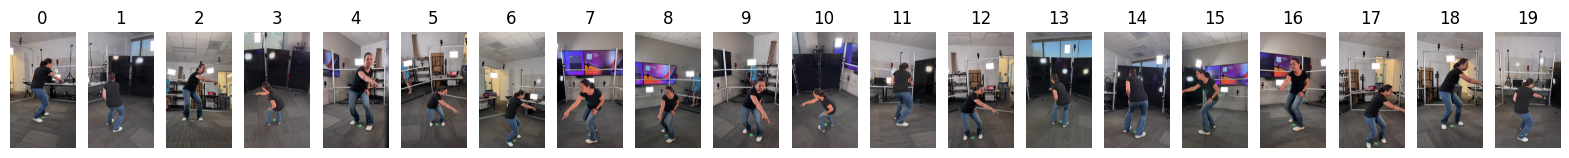

In [4]:
datapath = "D:/Data/human_body_data/2025-08-19-16-55-17"  # Replace with the actual path to your data
img_path = os.path.join(datapath, "images_unmasked", f"{118}")
cam_path = os.path.join(datapath, "splatfacto", f"{118}")
with open(os.path.join(cam_path, "transforms.json")) as f:
    cams_info_raw = json.load(f)
cams_data = create_cam_parms(cams_info_raw)
images, cams = load_images_from_folder(img_path, cams_data=cams_data, masked=False, showImg=True, new_recordings=True)

In [5]:
view_ids = [4,5,8,9,12,16]# specify which views to show
image_names = [list(images.keys())[i] for i in view_ids]

In [6]:
prediction.extrinsics

array([[[ 9.9999088e-01,  7.8574847e-04, -4.1973153e-03,  2.4867970e-03],
        [-7.8638602e-04,  9.9999970e-01, -1.5024559e-04,  5.3830849e-05],
        [ 4.1971961e-03,  1.5354491e-04,  9.9999118e-01, -6.4518192e-04]],

       [[ 8.0530292e-01,  9.8600142e-02, -5.8460689e-01,  9.0915447e-01],
        [-3.2126853e-01,  9.0131927e-01, -2.9053417e-01,  9.2145461e-01],
        [ 4.9827075e-01,  4.2178386e-01,  7.5751215e-01,  9.5653933e-01]],

       [[ 8.7027091e-01, -7.1392015e-02,  4.8737225e-01, -8.6726171e-01],
        [ 1.1730231e-01,  9.9101293e-01, -6.4292520e-02,  5.7764876e-01],
        [-4.7840220e-01,  1.1312179e-01,  8.7082422e-01,  5.0391400e-01]],

       [[ 9.9979270e-01, -1.0625882e-02,  1.7367495e-02,  6.9634761e-03],
        [ 1.3849663e-02,  9.8018956e-01, -1.9757673e-01,  6.5082330e-01],
        [-1.4924010e-02,  1.9777630e-01,  9.8013359e-01,  1.4260478e-01]],

       [[ 7.4926031e-01,  6.8894155e-02, -6.5868253e-01,  7.7832097e-01],
        [-1.3795574e-01,  9.88

In [7]:
import glob, os, torch
from depth_anything_3.api import DepthAnything3
from scipy.spatial.transform import Rotation

#check camera estimation against ground truth
def compare_camera_poses(estimated_extrinsics, ground_truth_cams, view_ids):
    """
    Compares estimated camera poses against ground truth for a set of cameras.
    The first camera in view_ids is used as the reference for all relative comparisons.
    """
    if len(view_ids) < 2:
        print("Error: Need at least two cameras to compare.")
        return

    # --- 1. Data Preparation ---
    # Extract and prepare all camera poses (convert from w2c to c2w)
    vggt_poses_c2w = []
    for i in range(len(view_ids)):
        # The model provides world-to-camera (w2c) matrices
        w2c = estimated_extrinsics[i]
        w2c_hom = np.vstack((w2c, np.array([0, 0, 0, 1])))
        # Invert to get camera-to-world (c2w)
        c2w = np.linalg.inv(w2c_hom)
        vggt_poses_c2w.append(c2w)

    real_poses_c2w = []
    all_gt_cams = list(ground_truth_cams.values())
    for i in view_ids:
        # Ground truth is already camera-to-world (c2w)
        c2w = all_gt_cams[i]["M"].copy()
        # Correct for different coordinate system conventions if necessary
        c2w[:, 1] = -c2w[:, 1]
        c2w[:, 2] = -c2w[:, 2]
        real_poses_c2w.append(c2w)

    # --- 2. Select Reference Cameras ---
    real_ref_c2w = real_poses_c2w[0]
    vggt_ref_c2w = vggt_poses_c2w[0]
    
    real_ref_pos = real_ref_c2w[:3, 3]
    vggt_ref_pos = vggt_ref_c2w[:3, 3]
    
    real_ref_R = real_ref_c2w[:3, :3]
    vggt_ref_R = vggt_ref_c2w[:3, :3]

    print(f"Comparing {len(view_ids) - 1} cameras against reference camera (View ID: {view_ids[0]})")
    print("=" * 80)

    # --- 3. Loop and Compare Each Camera to the Reference ---
    for i in range(1, len(view_ids)):
        print(f"\n--- Comparison: Ref (View {view_ids[0]}) vs. Cam (View {view_ids[i]}) ---")
        
        real_cam_c2w = real_poses_c2w[i]
        vggt_cam_c2w = vggt_poses_c2w[i]

        # --- Analysis: Baseline (Distance from Reference) ---
        real_pos = real_cam_c2w[:3, 3]
        vggt_pos = vggt_cam_c2w[:3, 3]
        
        real_baseline = np.linalg.norm(real_pos - real_ref_pos)
        vggt_baseline = np.linalg.norm(vggt_pos - vggt_ref_pos)
        
        scale_factor = real_baseline / vggt_baseline if vggt_baseline > 1e-6 else 0
        
        print(f"\n[Baseline Distance from Ref]")
        print(f"  Real: {real_baseline:.4f} meters")
        print(f"  VGGT: {vggt_baseline:.4f} (arbitrary units)")
        print(f"  => Scale Factor: {scale_factor:.4f}")

        # --- Analysis: Relative Rotation ---
        real_cam_R = real_cam_c2w[:3, :3]
        vggt_cam_R = vggt_cam_c2w[:3, :3]

        # Relative rotation: R_rel = R_cam * R_ref^T
        real_R_rel = real_cam_R @ real_ref_R.T
        vggt_R_rel = vggt_cam_R @ vggt_ref_R.T

        real_angle = np.linalg.norm(Rotation.from_matrix(real_R_rel).as_rotvec()) * 180 / np.pi
        vggt_angle = np.linalg.norm(Rotation.from_matrix(vggt_R_rel).as_rotvec()) * 180 / np.pi
        
        print(f"\n[Relative Rotation from Ref]")
        print(f"  Real Angle: {real_angle:.2f}°")
        print(f"  VGGT Angle: {vggt_angle:.2f}°")
        print(f"  => Rotation Error: {abs(real_angle - vggt_angle):.2f}°")

        # --- Analysis: Direction Vector ---
        real_direction = (real_pos - real_ref_pos) / real_baseline if real_baseline > 1e-6 else np.zeros(3)
        vggt_direction = (vggt_pos - vggt_ref_pos) / vggt_baseline if vggt_baseline > 1e-6 else np.zeros(3)
        
        direction_similarity = np.dot(real_direction, vggt_direction)
        direction_angle_error = np.arccos(np.clip(direction_similarity, -1, 1)) * 180 / np.pi

        print(f"\n[Direction Vector from Ref]")
        print(f"  Similarity (dot product): {direction_similarity:.4f}")
        print(f"  => Direction Angle Error: {direction_angle_error:.2f}°")

    print("\n" + "=" * 80)
    print("Comparison Complete.")

In [8]:
compare_camera_poses(prediction.extrinsics, cams, view_ids)

Comparing 5 cameras against reference camera (View ID: 4)

--- Comparison: Ref (View 4) vs. Cam (View 5) ---

[Baseline Distance from Ref]
  Real: 1.7605 meters
  VGGT: 1.6081 (arbitrary units)
  => Scale Factor: 1.0948

[Relative Rotation from Ref]
  Real Angle: 42.39°
  VGGT Angle: 42.73°
  => Rotation Error: 0.34°

[Direction Vector from Ref]
  Similarity (dot product): -0.3507
  => Direction Angle Error: 110.53°

--- Comparison: Ref (View 4) vs. Cam (View 8) ---

[Baseline Distance from Ref]
  Real: 1.2574 meters
  VGGT: 1.1594 (arbitrary units)
  => Scale Factor: 1.0845

[Relative Rotation from Ref]
  Real Angle: 30.81°
  VGGT Angle: 30.24°
  => Rotation Error: 0.57°

[Direction Vector from Ref]
  Similarity (dot product): 0.1701
  => Direction Angle Error: 80.20°

--- Comparison: Ref (View 4) vs. Cam (View 9) ---

[Baseline Distance from Ref]
  Real: 0.7124 meters
  VGGT: 0.6662 (arbitrary units)
  => Scale Factor: 1.0693

[Relative Rotation from Ref]
  Real Angle: 11.46°
  VGGT 

In [40]:
cams_copy = [list(cams.values())[i] for i in view_ids]
cams_copy = correct_camera_poses(cams_copy)
extrinsics_array = world_to_camera(cams_copy)
extrinsics_array = np.array(extrinsics_array)


In [41]:
intrinsics_array = np.array([list(cams.values())[i]["K"] for i in view_ids])
intrinsics_array/=2
intrinsics_array

array([[[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[6.3574921e+02, 0.0000000e+00, 2.6755820e+02],
        [0.0000000e+00, 6.3574921e+02, 4.8081113e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]]]

In [36]:
prediction = model.inference( 
   image_names,
    extrinsics=extrinsics_array,  # (N, 4, 4)
 #   intricsintrinsics_arrayy,  # (N, 3, 3)ns,
    export_dir="./output",
    export_format="npz-glb-gs_ply-gs_video",
    align_to_inpuscale=True=False,
    infer_gs=True,  # Required for gs_ply and gsexports_videprocess_res=960,s=504,ts
)

[INFO ] Processed Images Done taking 0.1249082088470459 seconds. Shape:  torch.Size([6, 3, 966, 546])
[INFO ] Using camera conditions provided by the user
[INFO ] Using camera conditions provided by the user
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000


[INFO ] Processed Images Done taking 0.1249082088470459 seconds. Shape:  torch.Size([6, 3, 966, 546])
[INFO ] Using camera conditions provided by the user
[INFO ] Using camera conditions provided by the user
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000


[INFO ] Processed Images Done taking 0.1249082088470459 seconds. Shape:  torch.Size([6, 3, 966, 546])
[INFO ] Using camera conditions provided by the user
[INFO ] Using camera conditions provided by the user
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000


Moviepy - Building video ./output\gs_video/0000_extend.mp4.
Moviepy - Writing video ./output\gs_video/0000_extend.mp4



[INFO ] Processed Images Done taking 0.1249082088470459 seconds. Shape:  torch.Size([6, 3, 966, 546])
[INFO ] Using camera conditions provided by the user
[INFO ] Using camera conditions provided by the user
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000


Moviepy - Building video ./output\gs_video/0000_extend.mp4.
Moviepy - Writing video ./output\gs_video/0000_extend.mp4



[INFO ] Processed Images Done taking 0.1249082088470459 seconds. Shape:  torch.Size([6, 3, 966, 546])
[INFO ] Using camera conditions provided by the user
[INFO ] Using camera conditions provided by the user
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] Model Forward Pass Done. Time: 13.633607387542725 seconds
[INFO ] Conversion to Prediction Done. Time: 0.007000446319580078 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 1000000
[INFO ] Exporting to GLB with num_max_points: 1000000


Moviepy - Building video ./output\gs_video/0000_extend.mp4.
Moviepy - Writing video ./output\gs_video/0000_extend.mp4



Moviepy - Done !
Moviepy - video ready ./output\gs_video/0000_extend.mp4
[INFO ] Export Results Done. Time: 12.284878492355347 seconds


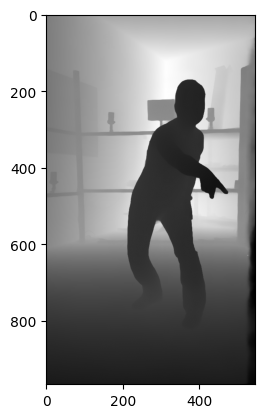

In [37]:
plt.imshow(prediction.depth[0],cmap='gray')


In [38]:
intrinsics_array

array([[[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[6.3574921e+02, 0.0000000e+00, 2.6755820e+02],
        [0.0000000e+00, 6.3574921e+02, 4.8081113e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]],

       [[7.0618225e+02, 0.0000000e+00, 2.7124878e+02],
        [0.0000000e+00, 7.0618225e+02, 4.8568161e+02],
        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]]]

In [43]:
import open3d as o3d
import numpy as np

# --- Configuration ---
# Select which views to generate point clouds for.
# Use `range(len(image_names))` to process all views.
views_to_process = [0, 1, 2, 3, 4, 5] 

# --- Point Cloud Generation ---
pcds = []
print(f"Generating point clouds for {len(views_to_process)} views...")

for i in views_to_process:
    # Get data for the current view
    depth = prediction.depth[i]
    image = prediction.processed_images[i]
    K = intrinsics_array[i]  # Use intrinsics corresponding to the processed image size
    w2c = extrinsics_array[i]     # World-to-camera extrinsics

    # Get image dimensions and intrinsics
    H, W = depth.shape
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Create a grid of pixel coordinates
    u = np.arange(W)
    v = np.arange(H)
    u, v = np.meshgrid(u, v)

    # Unproject pixels to 3D points in camera coordinates
    Z = depth
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy
    
    # Stack points into (H*W, 3) array
    points_camera_space = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
    
    # Get colors for each point
    colors = image.reshape(-1, 3) / 255.0

    # --- Manual Transformation using Linear Algebra ---
    # Get the camera-to-world (c2w) transformation matrix
    c2w = np.linalg.inv(w2c)

    # 1. Convert 3D camera points to 4D homogeneous coordinates
    num_points = points_camera_space.shape[0]
    points_cam_hom = np.hstack((points_camera_space, np.ones((num_points, 1))))

    # 2. Transform points to world space by matrix multiplication
    # We need to transpose points for multiplication: (4, 4) @ (4, N)
    points_world_hom = (c2w @ points_cam_hom.T).T

    # 3. Convert 4D world points back to 3D Cartesian coordinates
    # This involves dividing by the 4th component (w), which is usually 1
    points_world = points_world_hom[:, :3] / points_world_hom[:, 3, np.newaxis]
    
    # Create the final Open3D point cloud in world space
    pcd_world = o3d.geometry.PointCloud()
    pcd_world.points = o3d.utility.Vector3dVector(points_world)
    pcd_world.colors = o3d.utility.Vector3dVector(colors)
    
    pcds.append(pcd_world)
    print(f"  - View {i} processed.")

# --- Visualization ---
print("\nVisualizing point clouds. Close the window to continue.")
o3d.visualization.draw_geometries(pcds, window_name="Generated Point Clouds")

Generating point clouds for 6 views...
  - View 0 processed.
  - View 1 processed.
  - View 2 processed.
  - View 3 processed.
  - View 4 processed.
  - View 5 processed.

Visualizing point clouds. Close the window to continue.
